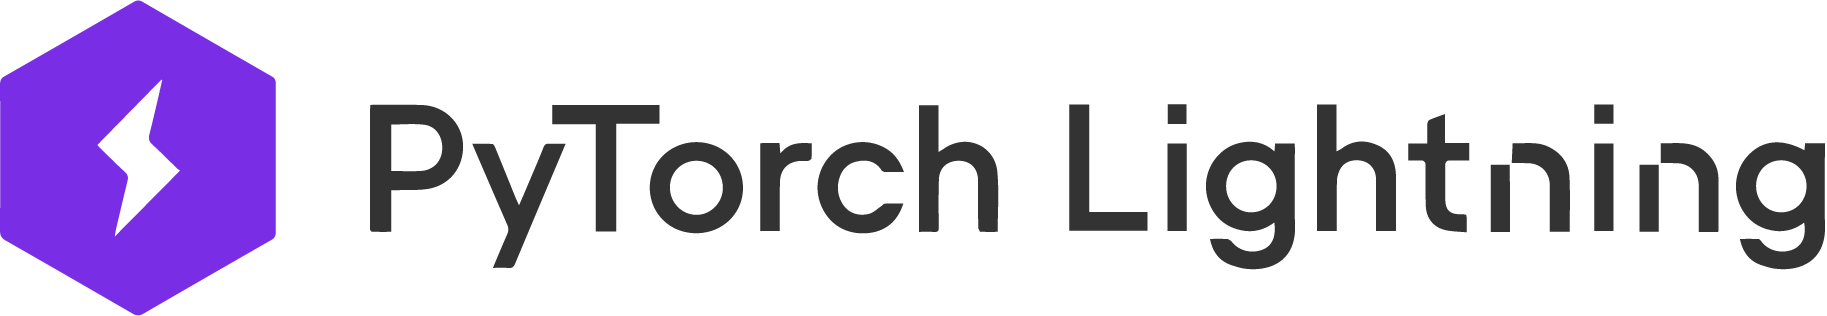

In [4]:
%%capture

!apt-get update && apt-get install -y xvfb
!pip install swig
!pip install gym[box2d]==0.23.1 
!pip install pytorch-lightning==1.6.0 

!pip install pyvirtualdisplay
!apt install xvfb


#### Setup virtual display

In [5]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [6]:
import copy
import gym
import torch
import random

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import Tensor, nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from pytorch_lightning.callbacks import EarlyStopping

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()


In [7]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

#### Create the Deep Q-Network

In [8]:
class DQN(nn.Module):

    def __init__(self , hidden_size , obs_size , n_actions):  
        super().__init__()
        self = nn.Sequential(

            nn.Linear(obs_size , hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size , hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size , n_actions)

        )

    def forward(self , x):
        
        return self.net(x.float())

#### Create the policy

In [9]:
def epsilon_greedy(state  , env , net , epsilon= 0.0):
    if np.random.random() < epsilon:

        action = env.action_space.sample()

    else:
        state = torch.tensor([state]).to(device)
        q_values = net(state)
        _ , action = torch.max(q_values , dim=1)

        action = int(action.item())

    return action

#### Create the replay buffer

In [10]:
class ReplayBuffer:

    def __init__(self , capacity):

        self.buffer = deque(maxlen= capacity)

    def __len__(self):

        return len(self.buffer)
    
    def append(self, experience):
        self.buffer.append(experience)

    def sample(self , batch_size):
        return random.sample(self.buffer , batch_size)

In [11]:
from typing import Iterator


class RLDataset(IterableDataset):


    def __init__(self , buffer , sample_size = 200):

        self.buffer = buffer

        self.sample_size = sample_size


    def __iter__(self):
        for experience in self.buffer.sample(self.sample_size):

            yield experience

            

#### Create the environment

In [12]:
def create_environment(name):

    env = gym.make(name)

    env = TimeLimit(env , max_episode_steps= 400)

    env = RecordVideo(env , video_folder= './videos' , episode_trigger=lambda x : x % 50 == 0)

    env = RecordEpisodeStatistics(env)

    return env


#### Create the test/sampling function

In [13]:
env = create_environment('LunarLander-v2')
env.reset()

/home/navaneet/.local/lib/python3.8/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  @abstractmethod
/home/navaneet/.local/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
/home/navaneet/.local/lib/python3.8/site-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /home/navaneet/Desktop/GITHUB/Basic-Reinforcement-Learning/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  
/home/navaneet/.local/lib/python3.8/site-packages/gym/wrappers/monitoring/video_reco

array([-3.6277770e-04,  1.4156346e+00, -3.6752690e-02,  2.0952699e-01,
        4.2707927e-04,  8.3250115e-03,  0.0000000e+00,  0.0000000e+00],
      dtype=float32)

#### Create the Deep Q-Learning algorithm

In [14]:
from typing import Any

from pytorch_lightning.utilities.types import TRAIN_DATALOADERS, OptimizerLRScheduler


class DeepQlearning(LightningModule):

    def __init__(self, env_name, policy=epsilon_greedy, capacity=100_000, batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99, loss_fn=F.smooth_l1_loss, optim=AdamW,

                 eps_start=1.0, eps_end=0.15, eps_last_episode=100, samples_per_epoch=10_000, sync_rate=10):
        super().__init__()

        self.env = create_environment(env_name)
        obs_size = self.env.observation_space.shape[0]
        n_actions = self.env.action_space.n

        self.q_net = DQN(hidden_size, obs_size, n_actions)
        self.target_q_net = copy.deepcopy(self.q_net)
        self.policy = policy
        self.buffer = ReplayBuffer(capacity=capacity)
        self.save_hyperparameters()

        while len(self.buffer) < self.hparams.samples_per_epoch:
            print(f"{len(self.buffer)} samples in experience buffer. Filling ...")
            self.play_episode(epsilon=self.hparams.eps_start)

    @torch.no_grad()
    def play_episode(self, policy=None, epsilon=0.):
        state = self.env.reset()
        done = False
        while not done:
            if policy:
                action = policy(state, self.env, self.q_net, epsilon=epsilon)
            else:
                action = self.env.action_space.sample()

            next_state, reward, done, info = self.env.step(action)
            exp = (state, action, reward, done, next_state)
            self.buffer.append(exp)
            state = next_state

    def forward(self, x):
        return self.q_net(x)

    def configure_optimizers(self):
        q_net_optimizer = self.hparams.optim(self.q_net.parameters(), lr=self.hparams.lr)
        return [q_net_optimizer]

    def train_dataloader(self):
        dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=self.hparams.batch_size)
        return dataloader

    def training_step(self, batch, batch_idx):
        states, actions, rewards, dones, next_states = batch
        actions = actions.unsqueeze(1)
        rewards = dones.unsqueeze(1)
        state_action_values = self.q_net(states).gather(1, actions)
        next_action_values, _ = self.target_q_net(next_states).max(dim=1, keepdim=True)
        next_action_values[dones] = 0.0
        # Main mathematical function
        expected_state_action_values = rewards + self.hparams.gamma * next_action_values
        loss = self.hparams.loss_fn(state_action_values, expected_state_action_values)
        self.log('episode/Q-Error', loss)
        return loss



#Training epoch END 
    

    def training_epoch_end(self , training_step_outputs):

        epsilon = max(

            self.hparams.eps_end,

            self.hparams.eps_start - self.current_epoch / self.hparams.eps_last_episode
        )


        self.play_episode(policy = self.policy , epsilon= epsilon )

        self.log('episode/Return' , self.env.return_queue[-1])

        if self.current_epoch % self.hparams.sync_rate == 0 :

            self.target_q_net.load_state_dict(self.q_net.state_dict())
    



#### Purge logs and run the visualization tool (Tensorboard)




In [15]:
!rm -r /content/lightning_logs/
!rm -r /content/videos/

%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

rm: cannot remove '/content/lightning_logs/': No such file or directory
rm: cannot remove '/content/videos/': No such file or directory
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 5152), started 0:03:01 ago. (Use '!kill 5152' to kill it.)

#### Train the policy

In [16]:
algo = DeepQlearning('LunarLander-v2')

trainer = Trainer(

    gpus = num_gpus,

    max_epochs=10_000 ,
    callbacks= [EarlyStopping(monitor= 'episode/Return' , mode= 'max' , patience= 500)]

    
)

trainer.fit(algo)

0 samples in experience buffer. Filling ...
65 samples in experience buffer. Filling ...
212 samples in experience buffer. Filling ...
283 samples in experience buffer. Filling ...
350 samples in experience buffer. Filling ...
439 samples in experience buffer. Filling ...
526 samples in experience buffer. Filling ...
612 samples in experience buffer. Filling ...
695 samples in experience buffer. Filling ...
784 samples in experience buffer. Filling ...


/home/navaneet/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 


878 samples in experience buffer. Filling ...
963 samples in experience buffer. Filling ...
1103 samples in experience buffer. Filling ...
1187 samples in experience buffer. Filling ...
1246 samples in experience buffer. Filling ...
1328 samples in experience buffer. Filling ...
1408 samples in experience buffer. Filling ...
1521 samples in experience buffer. Filling ...
1606 samples in experience buffer. Filling ...
1683 samples in experience buffer. Filling ...
1796 samples in experience buffer. Filling ...
1924 samples in experience buffer. Filling ...
2059 samples in experience buffer. Filling ...
2123 samples in experience buffer. Filling ...
2188 samples in experience buffer. Filling ...
2321 samples in experience buffer. Filling ...
2429 samples in experience buffer. Filling ...
2514 samples in experience buffer. Filling ...
2582 samples in experience buffer. Filling ...
2672 samples in experience buffer. Filling ...
2765 samples in experience buffer. Filling ...
2853 samples in

Traceback (most recent call last):
  File "/home/navaneet/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4130/792108429.py", line 1, in <module>
    algo = DeepQlearning('LunarLander-v2')
  File "/tmp/ipykernel_4130/2262808775.py", line 25, in __init__
    self.play_episode(epsilon=self.hparams.eps_start)
  File "/home/navaneet/.local/lib/python3.8/site-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "/tmp/ipykernel_4130/2262808775.py", line 37, in play_episode
    next_state, reward, done, info = self.env.step(action)
  File "/home/navaneet/.local/lib/python3.8/site-packages/gym/wrappers/record_episode_statistics.py", line 113, in step
  File "/home/navaneet/.local/lib/python3.8/site-packages/gym/wrappers/record_video.py", line 176, in step
  File "/home/navaneet/.local/lib/python3.8/site-packages/gym/wra

#### Check the resulting policy

In [17]:
display_video(episode=0)

FileNotFoundError: [Errno 2] No such file or directory: '/content/videos/rl-video-episode-0.mp4'